In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from IPython import display
import os
#import re
import sys

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

#set path
sys.path.insert(1, '../')

In [2]:
from utils.reader_config import config_reader
config = config_reader('../config/config.json')

# fix random seed
random_seed = config.random_seed

# from utils.functions import print_metrics

In [3]:
path_figures = config.path_figures
path_data = os.path.join(config.path_data, 'recordings/') 
path_data

'../data/recordings/'

In [4]:
# import gdown # dowload moduld from google drive
# url = "https://drive.google.com/uc?id=1LpReiJ8hQJHbGBiv1Vsp2WDYdO2qaRtA"
# filename = "dst-3.0_16_1_hh_database.zip"
# path = 'data/'
# output = data_zip = os.path.join(path, filename)

# # Создадим папку data, если такой папки нет
# if not os.path.exists("data"):
#     os.mkdir("data")

# gdown.download(url, output=output, quiet=False)

In [5]:
# read the dataset
train_full_df = pd.read_csv(os.path.join(config.path_data, 'train.csv'))
train_full_df.head()


,file_name,speaker,label
0,8_lucas_9.wav,lucas,8
1,0_theo_17.wav,theo,0
2,1_theo_13.wav,theo,1
3,1_george_12.wav,george,1
4,5_jackson_14.wav,jackson,5


## Data Exploration

In the first step, the so-called Data Exploration, individual audio recordings are visualized and examined for first visible differences. From the available 3,000 recordings, a random recording is chosen for different digits and visualized as waveform and mel spectrogram.

Digit is : 1


Digit is : 3


Digit is : 6


Digit is : 8


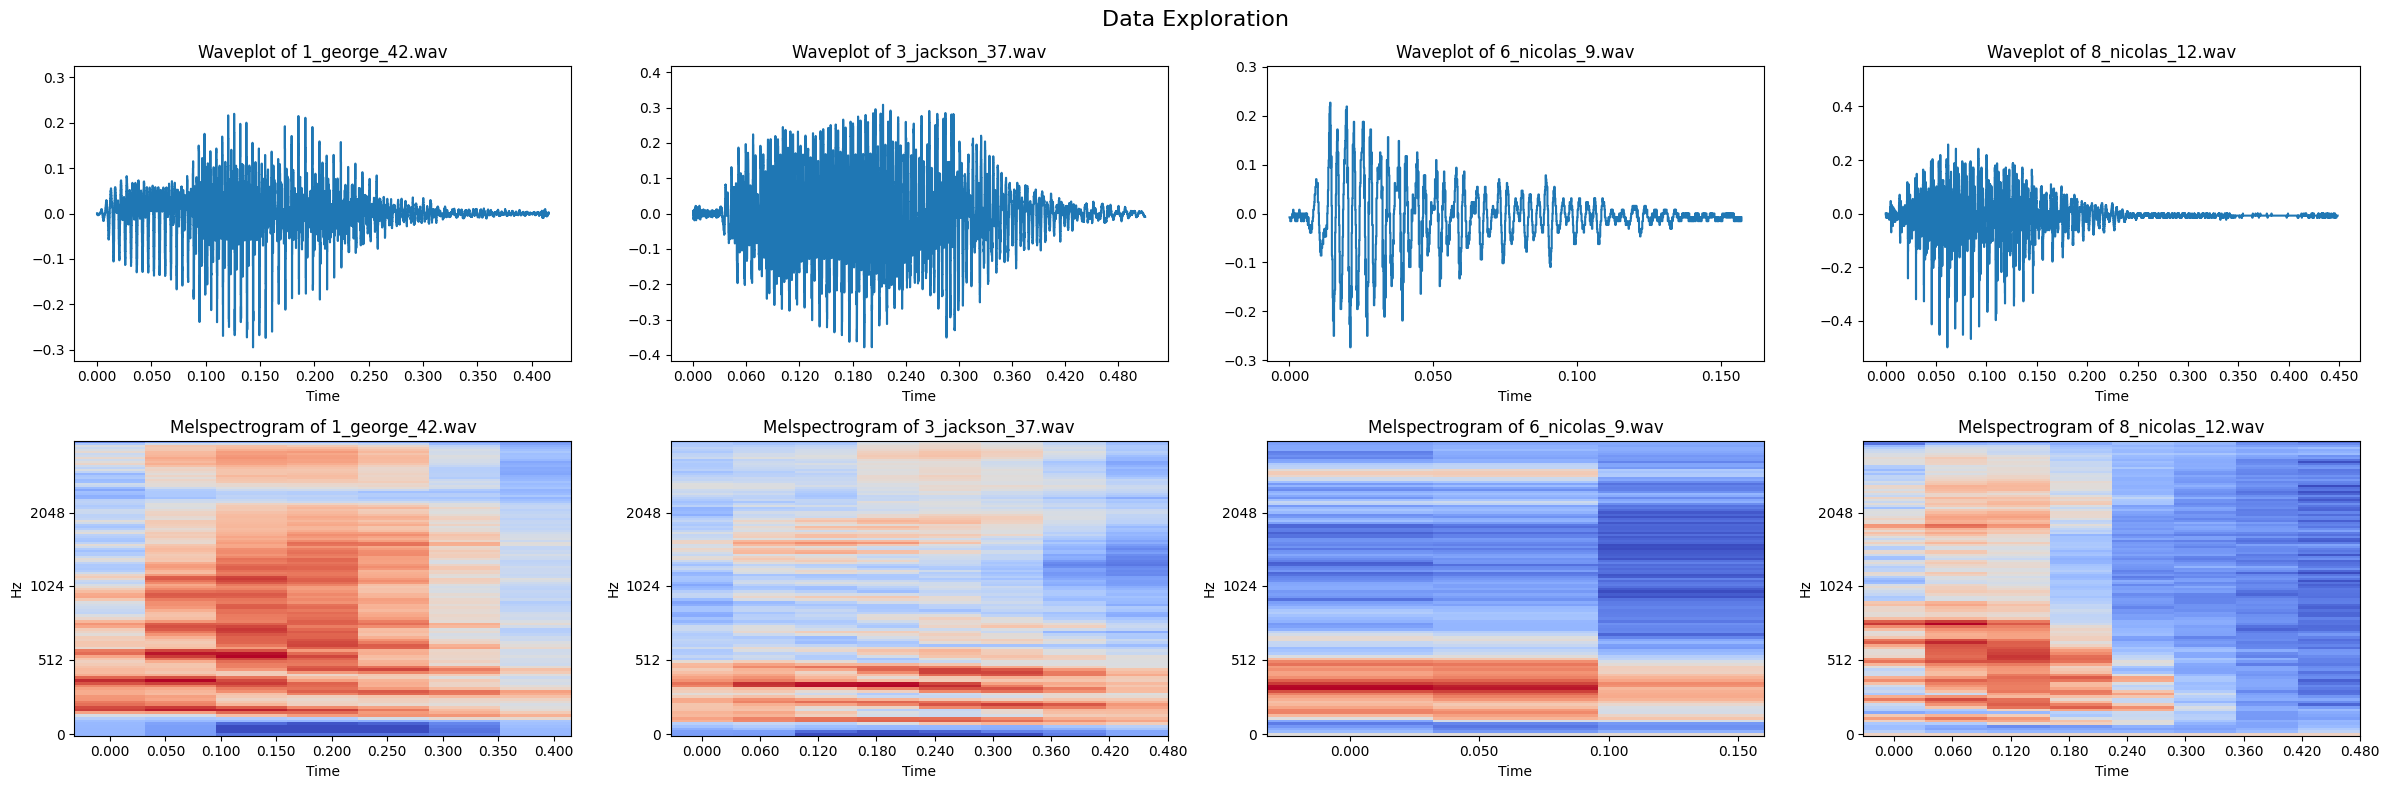

In [49]:
visualize_digits = [1, 3, 6, 8] #

description = pd.read_csv(os.path.join(config.path_data, 'train.csv'))

fig, ax = plt.subplots(nrows=2, ncols=(len(visualize_digits)))
ax = ax.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(24, 8)

for i, digit in enumerate(visualize_digits):
    # Select random file for selected digit
    rand_file = np.random.choice(description[description['label'] == digit]['file_name'])
    
    # Load audio and plot waveform and melspectrogram
    audio, sr = librosa.load(os.path.join(path_data, rand_file), sr=None)
    librosa.display.waveshow(y=audio, sr=sr, axis='time', ax=ax[i])# not waveplot
    ax[i].set(title=f'Waveplot of {rand_file}')
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    
    librosa.display.specshow(
        data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=ax[i+len(visualize_digits)])
    ax[i+len(visualize_digits)].set(title=f'Melspectrogram of {rand_file}')
    
    #print('Audio playback')
    print(f'Digit is : {digit}')
    display.display(display.Audio(audio, rate=16000))

plt.tight_layout()
plt.show()

## Feature Engineering

The next step is to extract features from the audio recordings, in this case a Melspectrogram. In order later train the neural network, all features must have the same shape. However, since the recordings are of different lengths, they are brought to a length of 1s by time-stretching. The features and labels of the recordings are stored in numpy arrays to be able to work with them easily later.

In [51]:
feature_list, label_list = [], []

# Iterate over all files in given source path
print('Preparing feature dataset and labels.')
for file in tqdm(os.listdir(path_data)):
    # Skip if it's not a wav file
    if not file.endswith('.wav'):
        continue
    
    # Load audio and stretch it to length 1s
    audio_path = os.path.join(path_data, file)
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)
    feature_list.append(mels_db.reshape((128, 16, 1)))
    label_list.append(file[0])
    
features = np.array(feature_list)
labels = np.array(label_list)

Preparing feature dataset and labels.


100%|██████████| 3000/3000 [00:48<00:00, 61.32it/s]


In [56]:
mels.shape

(128, 16)

In [53]:
display.display(display.Audio(audio, rate=16000))

## Model Architecture

After the data is prepared, the next step is to define the architecture or the structure of the neural network. Using the Keras Sequential API, the individual layers can be defined one after the other.

1. Input layer: In the first layer it is only defined which form the incoming data has. This does not necessarily be entered as a separate layer, but can also be defined in the subsequent layer.
Conv2D Layers & MaxPooling: The next part is the core of CNNs. Within the Convolutional Layers possible relevant correlations are determined from the data by kernels. The first number indicates in each case, how many filters are to be generated. The MaxPooling layer reduces the output of the previous layers by again running a kernel over the data and selecting the largest value from a 2×2 field.
2. Flatten & Dropout: The Flatten layer generates a 1-dimensional tensor/vector from an n-dimensional input. The Dropout layer randomly deactivates the given fraction of neurons per epoch. By this methodology the so-called overfitting (overfitting to the training data) can be reduced. 4 Dense 
3. Layers: Finally, the CNN contains a Dense Layer with 64 neurons as well as the actual classifier (layer with 10 neurons, one for each class). Through the Softmax activation function, values between 0 and 1 are emitted which can be seen as the probability for each class.

The network is then compiled with an optimizer, loss function as well as metrics.

In [ ]:
model = keras.Sequential(layers=[
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'), #activation=keras.activations.relu
        keras.layers.Dense(10, activation='softmax') #activation=keras.activations.softmax
    ])
model.compile(
    optimizer=keras.optimizers.Adam(), 
    loss=keras.losses.categorical_crossentropy, 
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 16, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 8, 16)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 8, 32)         4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 4, 32)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dropout (Dropout)           (None, 4096)              0

In [9]:
# config.callbacks = {
#     "model_name":"Model_voice",
#     "cooldown_epochs":1,
#     "lr":1e-4,
#     "reduce_patience":10,
#     "stop_patience":50,
#     "monitor":"val_accuracy",
#     "verbose":0,
#     "mode":"max",
#     "save_weights_only":True, 
#     "save_best_only": True,
#     "restore_best_weights": True,
#     "factor": 0.9
# }


In [10]:
from utils.models import  callbacks 
from utils.figures import plot_history
# Hides output while after model learned
from IPython.display import clear_output

In [57]:
# path_models = config.path_models
X_train.shape

(2100, 128, 16, 1)

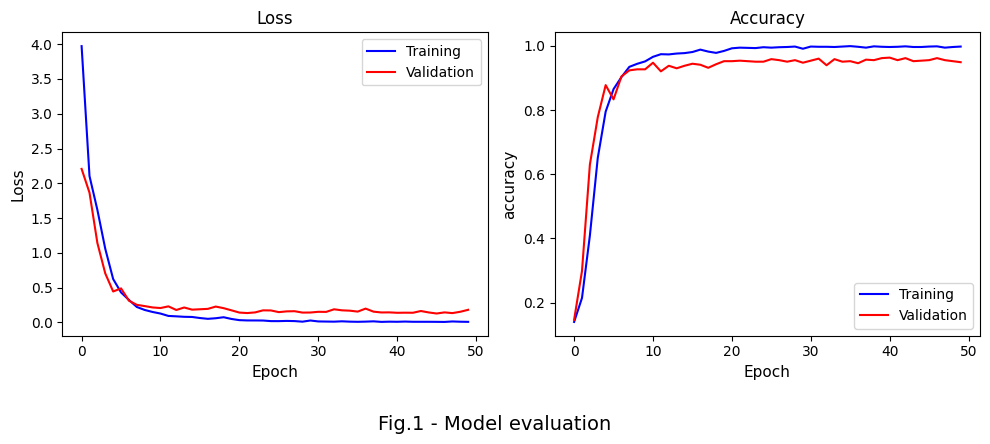

In [12]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 50

# Encode Labels
encoded_labels = tf.one_hot(indices=labels, depth=10)

# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(
    features, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x=X_train, 
    y=y_train, 
    validation_split=TEST_SIZE, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=callbacks(path_models=path_models, **config.callbacks) #[early_stopping] #
) 
clear_output(wait=False)
plot_history(history, path_figures='../figures/')#, plot_counter=36

## Evaluate the model

After training, the accuracy on new data can be determined using the test set that the model has not seen before. This indicates whether overfitting or underfitting is present, or the training has achieved a good result.

The results of the prediction can be displayed in a confusion matrix. This shows which class a recording really has and which class the model predicted. In the main diagonal the correct predictions can be found

29/29 [==============================] - 0s 6ms/step


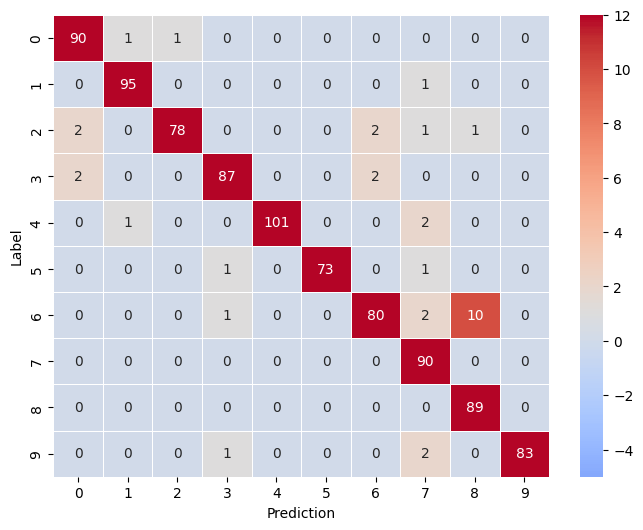

In [ ]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
mask = np.triu(confusion_matrix)
fig = plt.figure()
fig.set_size_inches(8, 6)

sns.heatmap(
    confusion_matrix, 
    xticklabels=label_names, 
    yticklabels=label_names, annot=True, fmt='g',  cmap='coolwarm',linewidths=.5, vmin=-5, vmax=12, center=1) # Set desired rang)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))